### GSEA analysis in regulons

* Done seperately for activators and repressors
* gmt file was genreated based on regulatory networks parsed from RegulonDB 9.4

In [1]:
import gseapy
import networkx as nx
import sys
sys.path.append('../methods')
from settings import *
import helpers
%matplotlib inline

config_dict = helpers.process_config("config")

# Output
figures_dir = config_dict["out_dir"]["figures"]
results_dir = config_dict["out_dir"]["results"]

# Strain Info

strain_info = pd.read_csv(strain_info_file, index_col=0)

# Regulon info
regulon_csv = config_dict["out_dir"]["regulon_csv"] # This was created using interacting_with_regulondb.py
regulon_gmt = config_dict["out_dir"]["regulon_gmt"]

# Counts/TPMs
deseq2_cnts_file = config_dict["data"]["deseq2_counts"]
sign_de_file = config_dict["data"]["sign_de_file"]

/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/methods/helpers.py


#### Generate .gmt file and run GSEA

In [3]:
regulon = pd.read_csv(regulon_csv, index_col=0)
regulon.head()

,regulator,regulated_name,regulated_bnum,regulator_function,conformation
0,fis,mglA,b2149,repressor,Fis
1,fis,deoC,b4381,activator,Fis
2,fis,deoB,b4383,activator,Fis
3,fis,deoD,b4384,activator,Fis
4,fis,dmsB,b0895,repressor,Fis


In [3]:
# Create gene set file
###
if os.path.isfile(regulon_gmt):
    os.remove(regulon_gmt)
for group_name, group  in regulon.groupby(["regulator_function", "regulator"]):
    with open(regulon_gmt, "a") as fo:
        fo.write("{}_{}\tNA\t{}\n".format(group_name[1],group_name[0],"\t".join(group.regulated_bnum.values)))            

In [4]:
# Using DESeq2 normalized counts 
ds_cnts =  pd.read_csv(deseq2_cnts_file, index_col=0)
print(ds_cnts.iloc[:, 0:4].head())
print(ds_cnts.shape)

# Setting up conditions vector
cls = ["UR","UTI"]*14

           HM01_UR     HM01_UTI     HM03_UR     HM03_UTI
b4182    43.611405    15.840477   48.441622    15.302001
b1960    52.567318   128.986742   84.708076   121.323006
b2866  1095.347156   119.935041  237.027186    18.581001
b0328   226.623549     4.525851  216.303498    22.953001
b1660   413.140182  1269.501094  763.408872  2015.492095
(2653, 28)


In [5]:
# Function to run gsea and edit resulting df

def run_gsea(data, gene_set, cls, outdir, fdr=0.05, file_name="test_run.csv"):
    gsea_run = gseapy.gsea(data=data, gene_sets=gene_set, cls=cls, outdir=outdir,
                           min_size=10, method="signal_to_noise") 
    result = pd.DataFrame(gsea_run.results).T
    result = result[["es", "nes", "pval", "fdr", "geneset_size", "matched_size", "genes"]].sort_values('fdr')
    results_short = (result[["nes", "fdr",  "geneset_size", "matched_size", "genes"]][result.fdr < fdr ]
                     .sort_values(["nes", "fdr"]))
    results_short.columns = ["NES", "FDR", "Regulon Size", "Matched Size", "Genes"]
    results_short.to_csv(os.path.join(outdir, file_name))
    return results_short
 
def gene_name_to_protein_name(name):
    return name[:3].capitalize() + name[3:].capitalize()

In [244]:
###
gene_set = regulon_gmt
ga = run_gsea(ds_cnts, gene_set, cls, results_dir, file_name='final_gsea_analysis.csv')

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [6]:
ga = pd.read_csv(os.path.join(results_dir, 'final_gsea_analysis.csv'), index_col=0)
ga['Function'] = [i.split("_")[1].capitalize() for i in ga.index]
ga.index = [gene_name_to_protein_name(i.split("_")[0]) for i in ga.index]
ga["Expression (higher in)"] = ["Patients"  if n < 0 else 'Urine' for n in ga.NES]
ga_pretty = (ga[['Function', "Expression (higher in)", 'Regulon Size', 'Matched Size', "NES", 'FDR']]
            .sort_values('NES', ascending=False))                  
ga_pretty
#fn = os.path.join(results_dir, "regulon_analysis_table.csv")
#ga_pretty.to_csv(fn)

,Function,Expression (higher in),Regulon Size,Matched Size,NES,FDR
Lrp,Repressor,Urine,85,27,2.290800,0.000000
NarL,Repressor,Urine,87,65,2.244358,0.000000
Lrp,Activator,Urine,38,19,2.212696,0.000000
MetJ,Repressor,Urine,15,14,2.128852,0.000834
Crp,Activator,Urine,425,277,2.121504,0.000667
CsgD,Activator,Urine,13,12,2.011977,0.002503
GadX,Activator,Urine,23,15,1.893503,0.009296
ModE,Activator,Urine,31,28,1.872896,0.010845
YdeO,Activator,Urine,18,14,1.819751,0.020021
Fur,Repressor,Urine,110,66,1.766587,0.027529


In [7]:
ga

,NES,FDR,Regulon Size,Matched Size,Genes,Function,Expression (higher in)
FadR,-1.987152,0.003425,12,11,"b1187,b1288,b2316,b4018,b0954,b3256,b2323,b109...",Activator,Patients
PurR,-1.752299,0.044103,31,31,"b2551,b2904,b2905,b2903,b0033,b0032,b2553,b231...",Repressor,Patients
Cra,-1.712186,0.042675,59,50,"b2097,b3956,b0118,b3919,b2712,b1818,b2388,b181...",Repressor,Patients
LexA,-1.696072,0.035860,59,43,"b0095,b1741,b2009,b0708,b0094,b0958,b1860,b008...",Repressor,Patients
FliZ,1.609490,0.047507,20,15,"b1040,b3510,b1038,b1042,b1492,b3509,b1039,b104...",Repressor,Urine
FhlA,1.625360,0.045141,30,15,"b2728,b2729,b2730,b2717,b2712,b2726,b2727,b272...",Activator,Urine
NarP,1.640636,0.042791,33,26,"b1671,b1669,b0975,b0976,b2202,b2204,b2199,b220...",Repressor,Urine
NarP,1.656759,0.040460,32,29,"b2202,b0872,b2204,b1797,b1796,b2199,b2206,b220...",Activator,Urine
RcsA,1.686156,0.034481,42,24,"b1482,b3510,b0095,b1492,b3509,b3506,b3516,b351...",Activator,Urine
GadE,1.694005,0.035157,70,38,"b0889,b3212,b1482,b3510,b0095,b1492,b3509,b350...",Activator,Urine


/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


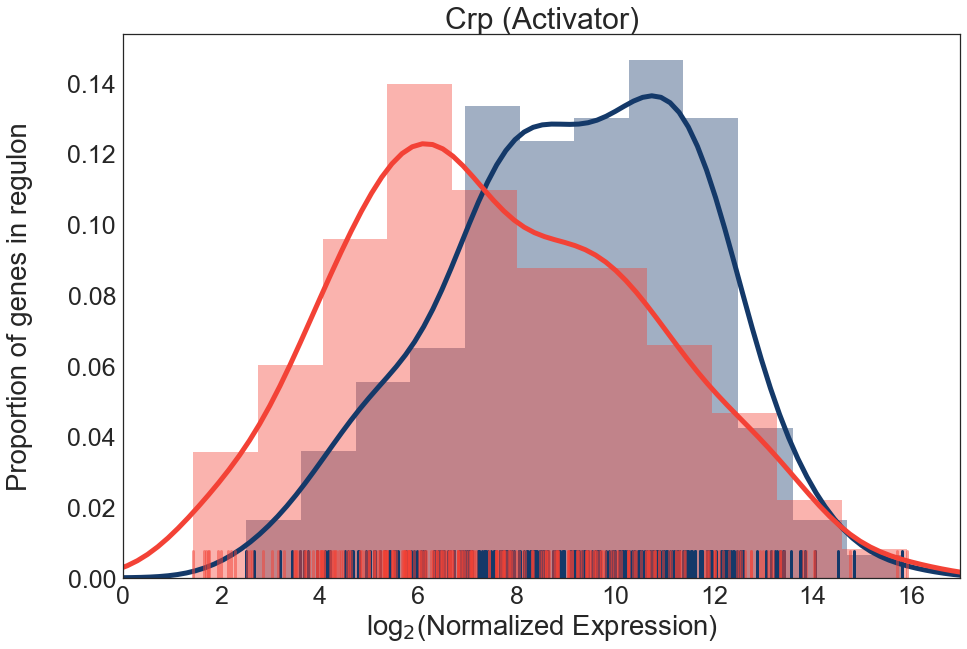

In [11]:
def plot_regulon_hist(regulator, function, ga, df_cnts, genes=""):
    if not genes:
        genes = ga[ga.Function==function].loc[regulator].Genes.split(",")
    df_ur = df_cnts[[c for c in df_cnts.columns if 'UR' in c]]
    df_uti = df_cnts[[c for c in df_cnts.columns if 'UTI' in c]]
    title = regulator + " ({})".format(function)
    urine = np.log2(df_ur.loc[genes]+1).mean(axis=1)
    patient = np.log2(df_uti.loc[genes]+1).mean(axis=1)
    sns.distplot(urine, color=col5, kde_kws={'linewidth':5})
    sns.rugplot(urine, color=col5,linewidth=3)
    sns.distplot(patient, color=col1, kde_kws={'linewidth':5})
    sns.rugplot(patient, color=col1,alpha=0.5, linewidth=3)
    plt.ylabel("Proportion of genes in regulon\n")
    plt.xlabel('log$_2$(Normalized Expression)')
    plt.title(title)

sns.set(font_scale = 2.5)
sns.set_style("white")
fig = plt.figure(figsize=(15,10))
plt.xlim(0,17)
plot_regulon_hist('Crp', 'Activator', ga, ds_cnts)
fn = os.path.join(figures_dir, "crp_urine.png")
#fig.savefig(fn)

In [8]:
lrp_genes = set([ gene for g in ga.loc['Lrp'].Genes.values for gene in g.split(",")])

In [9]:
urine_high = [('Crp', 'Activator'), ('Lrp', 'Dual', lrp_genes), ('NarL', 'Repressor'), ('MetJ', 'Repressor'),
              ('CsgD', 'Activator'), ('ModE', 'Activator'), ('GadX', 'Activator'), ('YdeO', 'Activator'), ]

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


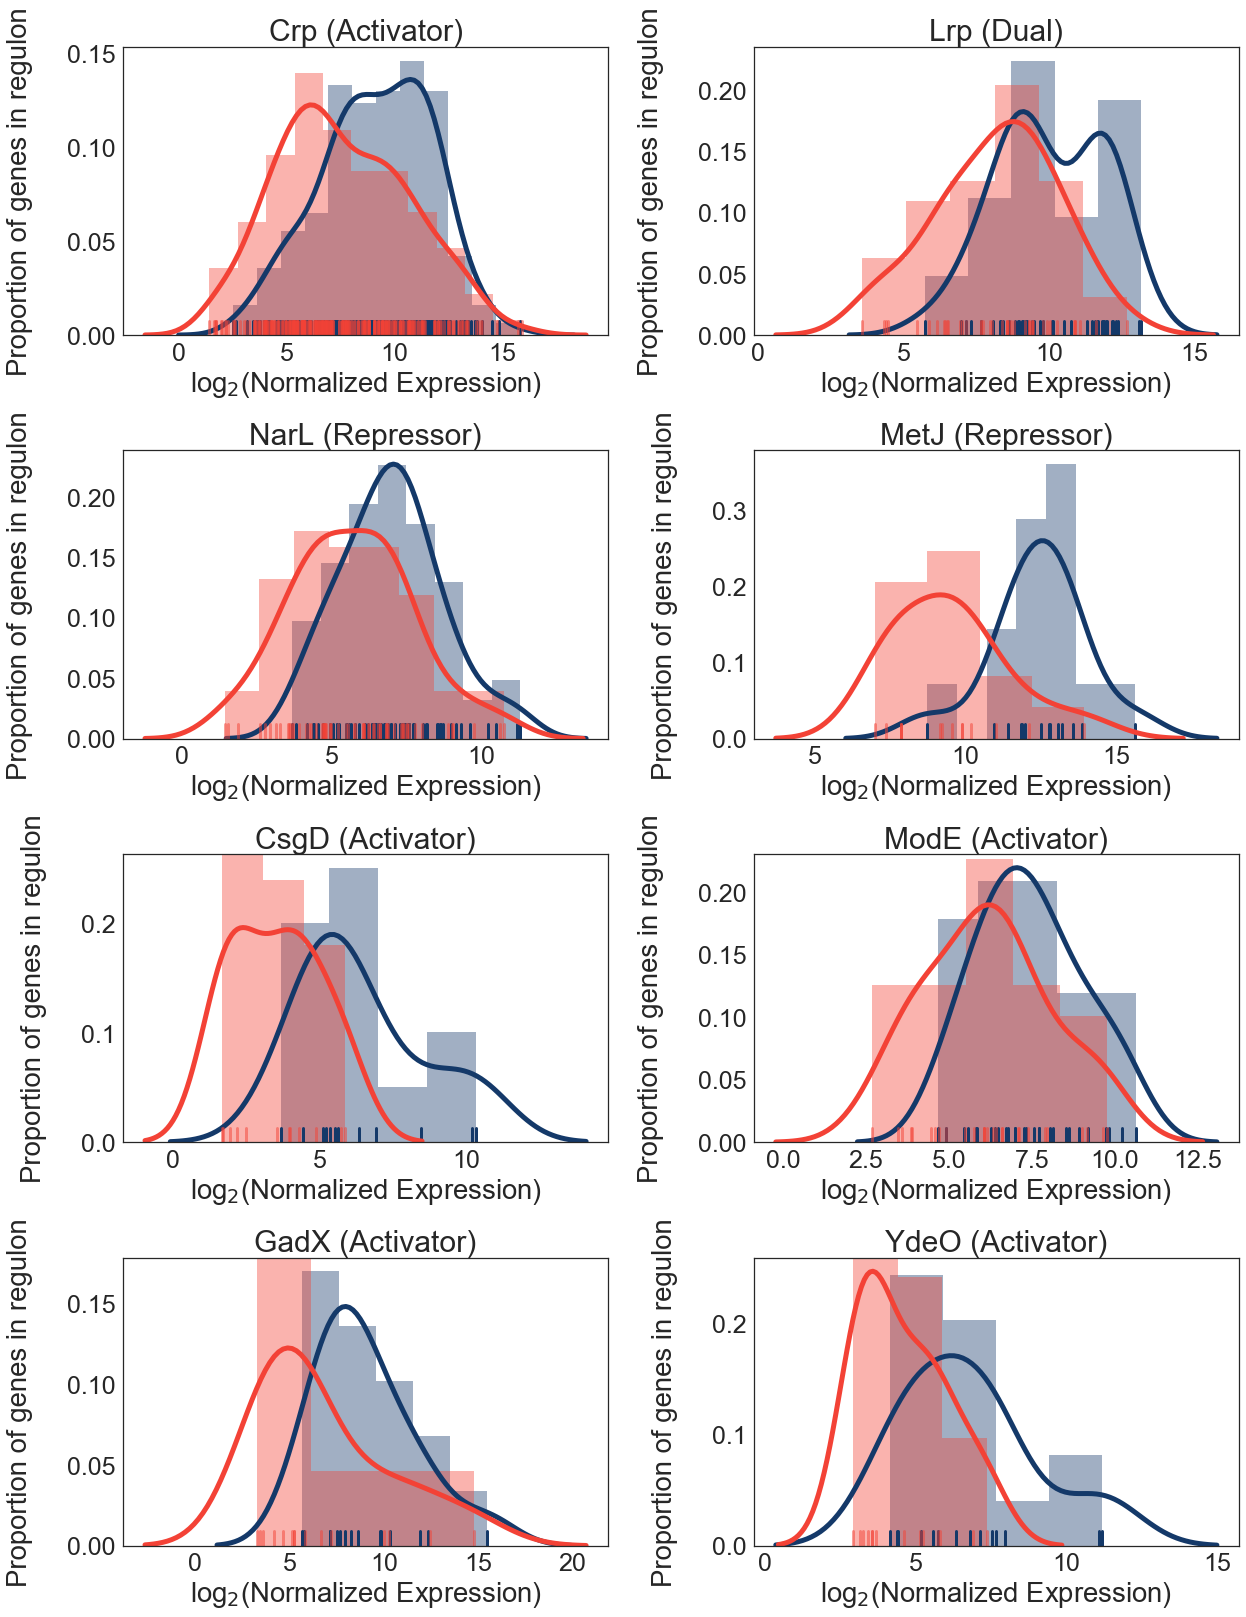

In [12]:
fig = plt.figure(figsize=(20, 35))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
for i, s  in enumerate(urine_high):  
    ax = fig.add_subplot(5, 2, i+1)
    if len(s) != 2:
        plot_regulon_hist(s[0], s[1], ga, ds_cnts, genes=s[2])
    else:
        plot_regulon_hist(s[0],s[1], ga, ds_cnts)

fn = os.path.join(figures_dir, "Figure_5.png")
fig.savefig(fn, dpi=100, bbox_inches="tight")

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


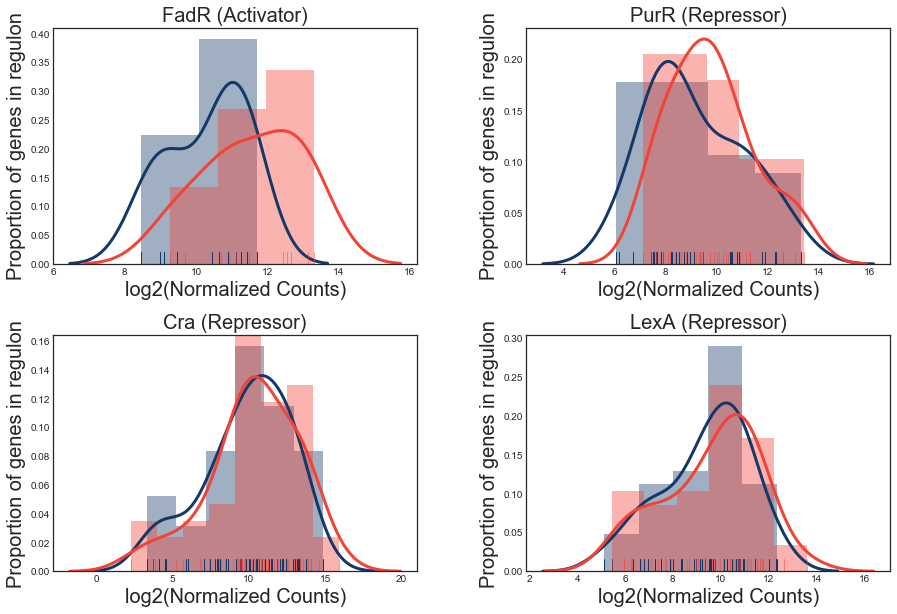

In [49]:
under = ga.head(4)
patient_high = [(i, f) for i, f in zip(under.index, under.Function)]
patient_high
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, s  in enumerate(patient_high):  
    ax = fig.add_subplot(2, 2, i+1)
    plot_regulon_hist(s[0], s[1], ga, ds_cnts)
fn = os.path.join(figures_dir, "Supplementary_Figure_3.png")
fig.savefig(fn, dpi=300, bbox_inches="tight")

In [10]:
ga = ga.sort_values(["NES","FDR"])
patient_activators = [i for i in ga[(ga.NES<0) & (ga.Function == 'Activator')].index]
print("Patient activators: {}".format(", ".join(patient_activators).strip(",")))
patient_repressors = [i for i in ga[(ga.NES>0) & (ga.Function == 'Repressor')].index]
print("Patient repressors: {}".format(", ".join(patient_repressors).strip(",")))
urine_activators = [i for i in ga[(ga.NES>0) & (ga.Function =='Activator')].index]
print("Urine activators: {}".format(", ".join(urine_activators).strip(",")))
urine_repressors = [i for i in ga[(ga.NES<0) & (ga.Function=='Repressor')].index]
print("Urine repressors: {}".format(", ".join(urine_repressors).strip(",")))


Patient activators: FadR
Patient repressors: FliZ, NarP, Hns, Fur, MetJ, NarL, Lrp
Urine activators: FhlA, NarP, RcsA, GadE, RcsB, PhoP, YdeO, ModE, GadX, CsgD, Crp, Lrp
Urine repressors: PurR, Cra, LexA


In [55]:
135+549

684

In [11]:
all_regulon_genes = set([gene for g in ga.Genes.values for gene in g.split(",")])
print("Number of genes in all the regulons: {}".format(len(all_regulon_genes)))
urine_high_genes = set([gene for g in ga[ga.NES>0].Genes.values for gene in g.split(',')])
print("Number of genes in Urine HIGH regulons: {}".format(len(urine_high_genes)))
patient_high_genes = set([gene for g in ga[ga.NES<0].Genes.values for gene in g.split(',')])
print("Number of genes in Patient HIGH regulons: {}".format(len(patient_high_genes)))
print("Number of genes in both: {}".format(len(patient_high_genes)+len(urine_high_genes)-len(all_regulon_genes)))

Number of genes in all the regulons: 637
Number of genes in Urine HIGH regulons: 549
Number of genes in Patient HIGH regulons: 135
Number of genes in both: 47


In [12]:
de_genes_df = pd.read_csv(sign_de_file, index_col=0)
de_genes = set(de_genes_df.index)
print("Number of differentially expressed genes: {}".format(len(de_genes)))
r = de_genes.intersection(all_regulon_genes)
pcnt_explained = len(r)/len(de_genes)*100
print("Percent differentially expressed genes in all regulons: {}%".format(round(pcnt_explained, 1)))

de_genes_down = set(de_genes_df[de_genes_df.log2FoldChange < 0].index)
r = de_genes_down.intersection(urine_high_genes)
pcnt_explained = len(r)/len(de_genes_down)*100
print("Percent downregulated genes in Urine-high regulons: {}%".format(round(pcnt_explained, 1)))


de_genes_up = set(de_genes_df[de_genes_df.log2FoldChange > 0].index)
r = de_genes_up.intersection(patient_high_genes)
pcnt_explained = len(r)/len(de_genes_up)*100
print("Percent upregulated genes in Patient-high regulons: {}%".format(round(pcnt_explained, 1)))

Number of differentially expressed genes: 494
Percent differentially expressed genes in all regulons: 39.3%
Percent downregulated genes in Urine-high regulons: 50.3%
Percent upregulated genes in Patient-high regulons: 6.0%


In [ ]:
#-------------------------------------->

In [13]:
t = regulon[regulon.regulator == 'lrp']

groups = t.groupby(['conformation', 'regulator_function'])
for i, d in groups:
    print(i)
    print(d.shape)
    plt.figure()
    x = "_".join(i)
    print(x)
    genes = [g for g in list(d.regulated_bnum) if g in ds_cnts.index]
    print(genes)
    #plot_regulon_hist(x.split("_")[0], x.split("_")[1], ga, ds_cnts, genes)

('Lrp', 'activator')
(27, 5)
Lrp_activator
['b2903', 'b2669', 'b2156', 'b3212', 'b2913', 'b4132', 'b0907', 'b2904', 'b1482', 'b2905', 'b0077', 'b0078', 'b3418', 'b3617']
('Lrp', 'repressor')
(33, 5)
Lrp_repressor
['b3456', 'b4187', 'b1190', 'b3769', 'b3454', 'b0078', 'b1243', 'b1247', 'b1482', 'b1245', 'b3771', 'b3770', 'b2912', 'b0889', 'b1244', 'b3455', 'b3457', 'b0077', 'b1246', 'b3772']
('Lrp-Leucine', 'activator')
(11, 5)
Lrp-Leucine_activator
['b2211', 'b2923', 'b2163', 'b2663', 'b2662', 'b3212']
('Lrp-Leucine', 'repressor')
(52, 5)
Lrp-Leucine_repressor
['b3769', 'b3508', 'b1798', 'b3572', 'b3510', 'b2290', 'b2913', 'b3772', 'b0889', 'b3771', 'b3509', 'b3770']


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

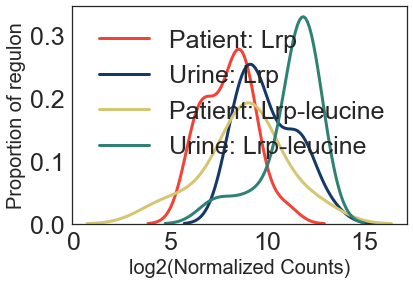

In [27]:

df_ur = ds_cnts[[c for c in ds_cnts.columns if 'UR' in c]]
df_uti = ds_cnts[[c for c in ds_cnts.columns if 'UTI' in c]]

#urine = np.log2(df_ur.loc[genes]+1).mean(axis=1)
d1 = groups.get_group(("Lrp", 'repressor')).regulated_bnum.values
d2 = groups.get_group(("Lrp-Leucine", 'repressor')).regulated_bnum.values

d1_v = np.log2(df_uti.loc[[d for d in d1 if d in df_uti.index]]+1).mean(axis=1)#ind
d2_v = np.log2(df_uti.loc[[d for d in d2 if d in df_uti.index]]+1).mean(axis=1)
d3_v = np.log2(df_ur.loc[[d for d in d1 if d in df_ur.index]]+1).mean(axis=1)#ind urine
d4_v = np.log2(df_ur.loc[[d for d in d2 if d in df_ur.index]]+1).mean(axis=1)
plt.xlabel("log2(Normalized Counts)", fontsize=20)
plt.ylabel("Proportion of regulon", fontsize=20)
sns.kdeplot(d1_v, color=col1, linewidth=3, label = "Patient: Lrp")
#sns.distplot(d2_v, color = col1, label='Lrp Leu')
sns.kdeplot(d3_v, color = col5, linewidth=3, label = "Urine: Lrp")
sns.kdeplot(d2_v, color=col2, linewidth=3, label = 'Patient: Lrp-leucine')
#sns.distplot(d2_v, color = col1, label='Lrp Leu')
sns.kdeplot(d4_v, color = col4, linewidth=3, label = "Urine: Lrp-leucine")

In [31]:
for i, g in groups:
    print(i)
    print(g)

('Lrp', 'activator')
     regulator regulated_name regulated_bnum regulator_function conformation
2698       lrp           gcvP          b2903          activator          Lrp
2702       lrp           aroA          b0908          activator          Lrp
2703       lrp           stpA          b2669          activator          Lrp
2704       lrp           fimA          b4314          activator          Lrp
2714       lrp           lysP          b2156          activator          Lrp
2721       lrp           cadA          b4131          activator          Lrp
2733       lrp           fimI          b4315          activator          Lrp
2745       lrp           gltB          b3212          activator          Lrp
2746       lrp           gltF          b3214          activator          Lrp
2748       lrp           serA          b2913          activator          Lrp
2759       lrp           cadB          b4132          activator          Lrp
2760       lrp           fimF          b4318          a

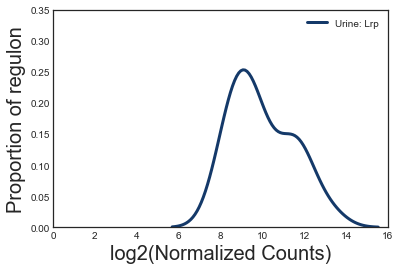

In [136]:
plt.xlabel("log2(Normalized Counts)", fontsize=20)
plt.ylabel("Proportion of regulon", fontsize=20)
plt.xlim(0,16)
plt.ylim(0, 0.35)
sns.kdeplot(d3_v, color = col5, linewidth=3, label = "Urine: Lrp")

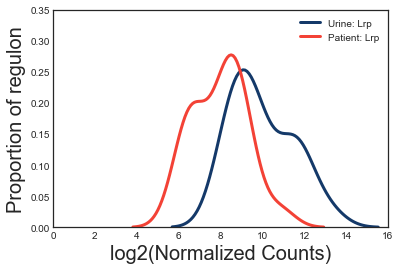

In [137]:
plt.xlabel("log2(Normalized Counts)", fontsize=20)
plt.ylabel("Proportion of regulon", fontsize=20)
plt.xlim(0,16)
plt.ylim(0, 0.35)
sns.kdeplot(d3_v, color = col5, linewidth=3, label = "Urine: Lrp")
sns.kdeplot(d1_v, color=col1, linewidth=3, label = "Patient: Lrp")

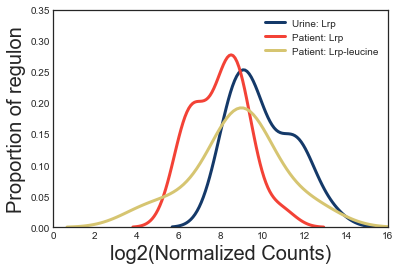

In [138]:
plt.xlabel("log2(Normalized Counts)", fontsize=20)
plt.ylabel("Proportion of regulon", fontsize=20)
plt.xlim(0,16)
plt.ylim(0, 0.35)
sns.kdeplot(d3_v, color = col5, linewidth=3, label = "Urine: Lrp")
sns.kdeplot(d1_v, color=col1, linewidth=3, label = "Patient: Lrp")
sns.kdeplot(d2_v, color=col2, linewidth=3, label = 'Patient: Lrp-leucine')

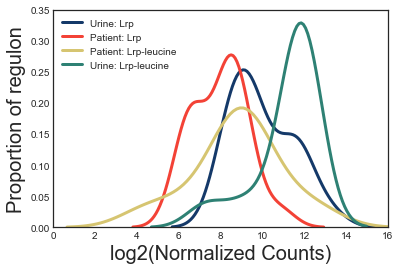

In [139]:
plt.xlabel("log2(Normalized Counts)", fontsize=20)
plt.ylabel("Proportion of regulon", fontsize=20)
plt.xlim(0,16)
plt.ylim(0, 0.35)
sns.kdeplot(d3_v, color = col5, linewidth=3, label = "Urine: Lrp")
sns.kdeplot(d1_v, color=col1, linewidth=3, label = "Patient: Lrp")
sns.kdeplot(d2_v, color=col2, linewidth=3, label = 'Patient: Lrp-leucine')
sns.kdeplot(d4_v, color = col4, linewidth=3, label = "Urine: Lrp-leucine")

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


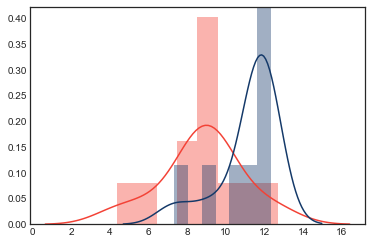

In [126]:
sns.distplot(d2_v, color=col1, )
#sns.distplot(d2_v, color = col1, label='Lrp Leu')
sns.distplot(d4_v, color = col5,)

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


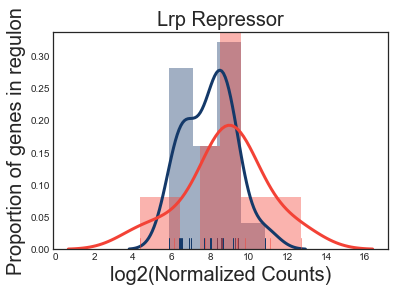

In [108]:
def plot_regulon_hist2(d1, d2, title, ga, df_cnts, genes=""):

    sns.distplot(d1, color=col5, kde_kws={'linewidth':3})
    sns.rugplot(d1, color=col5,)
    sns.distplot(d2, color=col1, kde_kws={'linewidth':3})
    sns.rugplot(d2, color=col1,alpha=0.5)
    plt.ylabel("Proportion of genes in regulon", fontsize=20)
    plt.xlabel('log2(Normalized Counts)', fontsize=20)
    plt.title(title, fontsize=20)
plot_regulon_hist2(d1_v, d2_v, "Lrp Repressor", ga, ds_cnts)

In [14]:
rreg = regulon[regulon.regulated_name.isin(regulon.regulator)]
rgroups = rreg.groupby('regulator')
graph = [(frm, t, clr) for frm, t, clr in  zip(rreg.regulator.values, rreg.regulated_name.values, rreg.regulator_function.values)]
len(set(graph))

472

In [34]:

def return_bin(lfc):
    if lfc < -2:
        return "#ffe7ab"
    elif lfc < -1:
        return "#ffe7ab"
    elif lfc > 1:
        return "#ffe7ab"
    elif lfc > 2:
        return "#ffe7ab"
    else:
        return "#ffe7ab"
lfc = pd.read_csv("/Users/annasintsova/git_repos/HUTI-RNAseq/results/differential_expression_analysis/media_all_genes_edited.csv",
                 index_col=0)
lfc_dict = {n:return_bin(L) for n, L in zip(lfc.Name,lfc.log2FoldChange)}




In [19]:
#nitrate_tf = ['csgD', 'mlrA', 'fliZ']
nitrate_tf = ['rcsA', 'csgD', 'gadE', 'gadX']
nitrate_df = regulon[regulon.regulator.isin(nitrate_tf)]
nitrate_df.shape

def get_graph_from_df(df):
    return [(frm, t, clr,) for frm, t, clr in  zip(df.regulator.values, df.regulated_name.values, df.regulator_function.values)]
g = get_graph_from_df(nitrate_df)

In [36]:
def draw_edges(G, pos, edge_list, e_color, w=2, ar=True, arsize=20):

    arrow = '-|>, head_length=1, head_width=.2'
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color=e_color, arrows=ar, width=w, arrowsize=arsize,arrowstyle=arrow)
    
    
def draw_graph(edge_list, val_map='', fs=(12,12),):
    #nodes = set([f[0] for f in edge_list if f in AGL] + [f[1] for f in edge_list])
   # print(nodes)
    
   
    fig = plt.figure(figsize=fs)
    el = [(f[0], f[1], f[2]) for f in edge_list if f[0] in AGL and f[1] in AGL]
    
    act_edges = [(f[0], f[1]) for f in el if f[2] == 'activator']
    
    rep_edges = [(f[0], f[1]) for f in el if f[2] == 'repressor']
    dual_edges = [(f[0], f[1]) for f in el if f[2] == 'dual']
    dual_edges += [(f[1], f[0]) for f in el if f[2] == 'dual']
    G = nx.DiGraph()
    G.add_edges_from(act_edges+rep_edges+dual_edges)
    to_remove = []
    if not val_map:
        values='skyblue'
    else:
        values = [val_map.get(node, '#eaeaea') for node in G.nodes()]
    pos = nx.circular_layout(G)
    
    nx.draw_networkx_labels(G, pos, font_size=16)
    nx.draw_networkx_nodes(G, pos,  node_color = values, node_size = 2000)
    draw_edges(G, pos, act_edges, 'r') #r
    draw_edges(G, pos, rep_edges, 'g')# g
    draw_edges(G, pos, dual_edges, 'k')
  

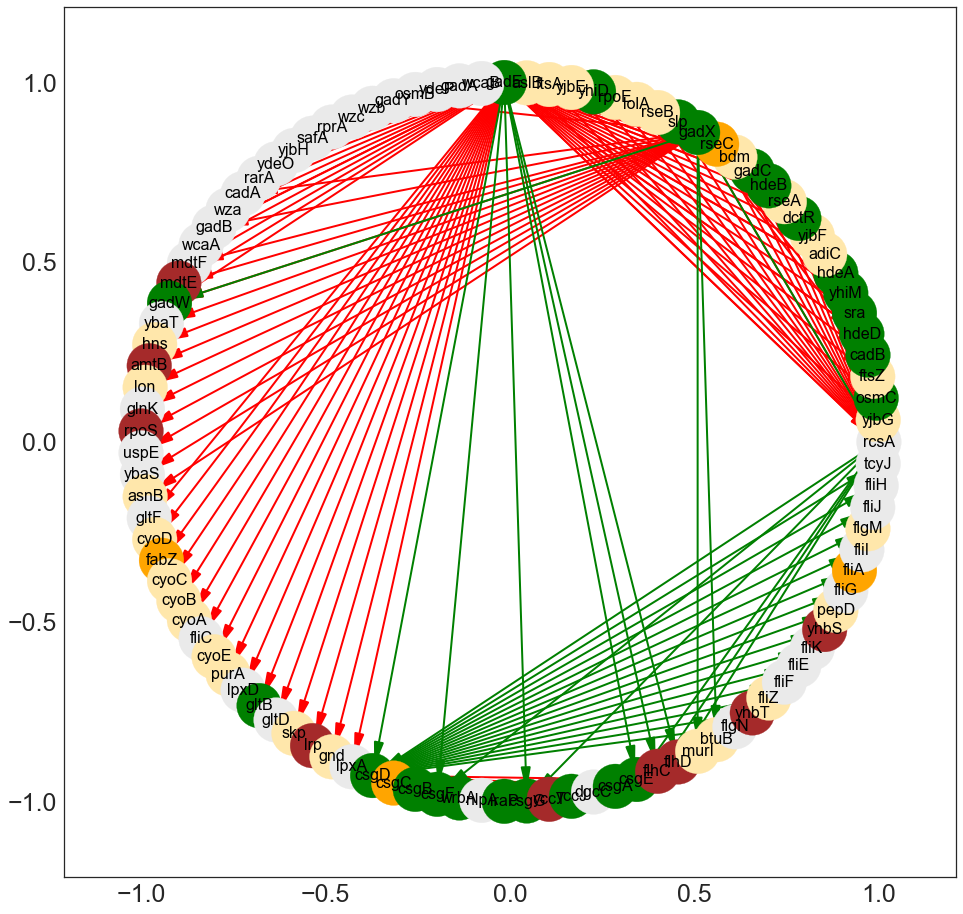

In [25]:
draw_graph(g, val_map=lfc_dict, fs=(16,16))

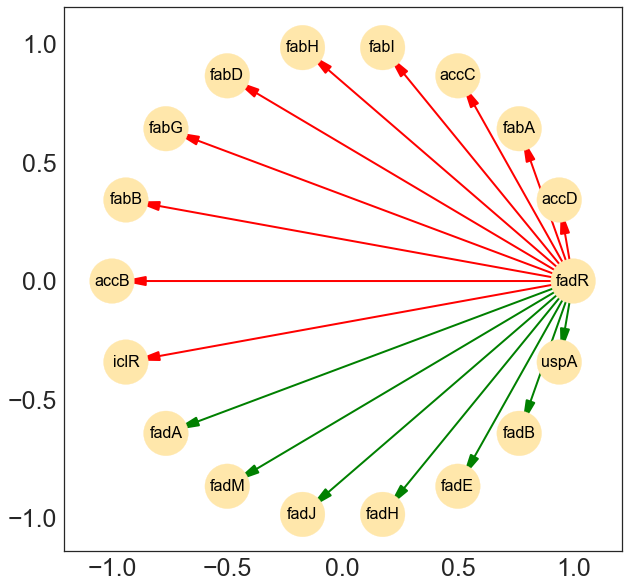

In [37]:
nitrate_tf = ['fadR']
nitrate_df = regulon[regulon.regulator.isin(nitrate_tf)]
nitrate_df.shape

def get_graph_from_df(df):
    return [(frm, t, clr,) for frm, t, clr in  zip(df.regulator.values, df.regulated_name.values, df.regulator_function.values)]

mode_graph =get_graph_from_df(nitrate_df)
draw_graph(mode_graph, val_map=lfc_dict, fs=(10,10))

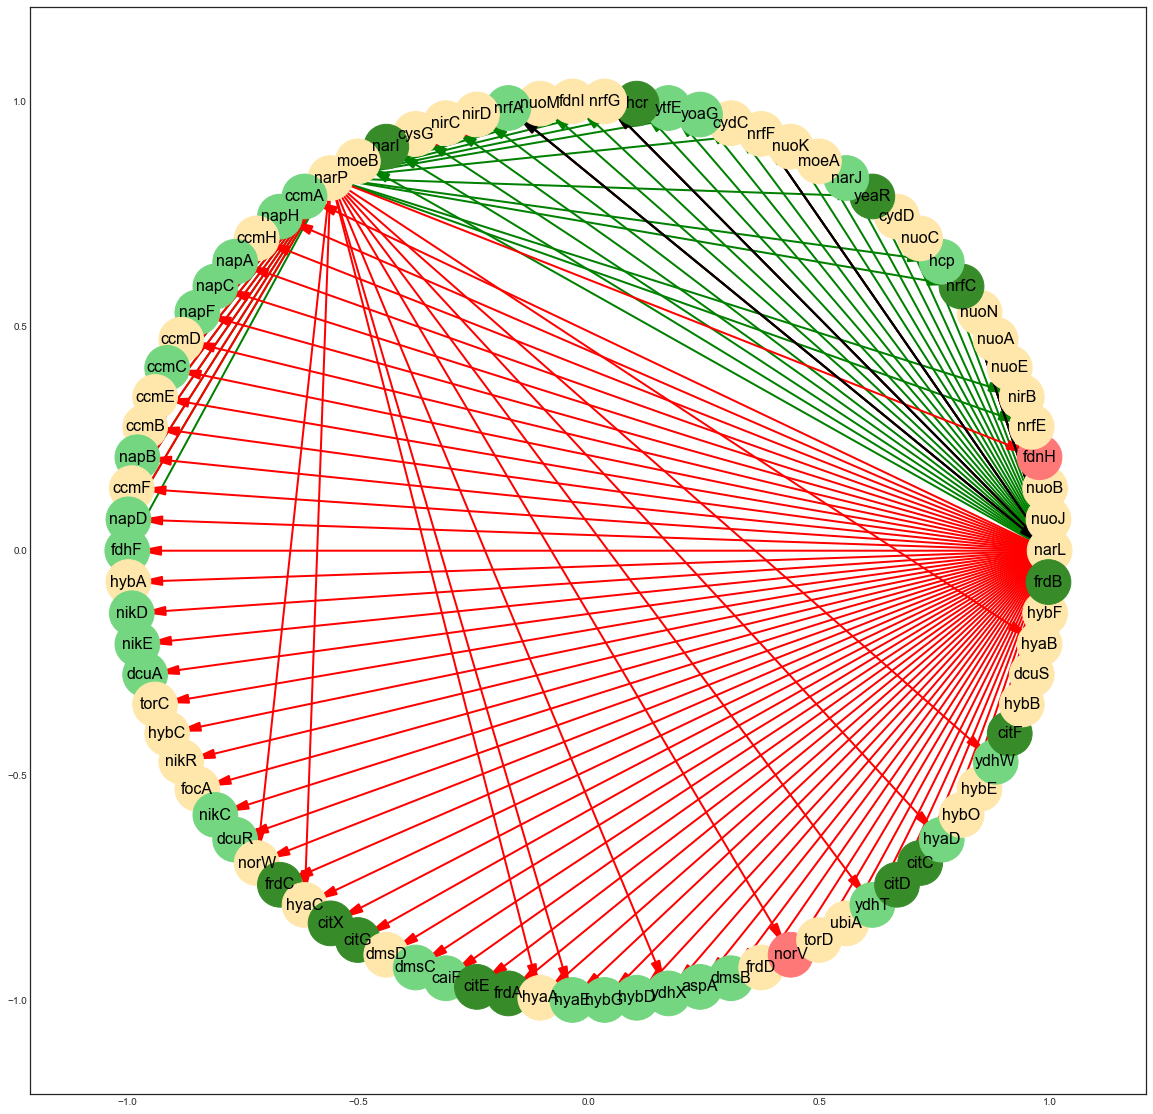

In [150]:
nitrate_tf = ['narL', 'narP']
nitrate_df = regulon[regulon.regulator.isin(nitrate_tf)]
nitrate_df.shape

def get_graph_from_df(df):
    return [(frm, t, clr,) for frm, t, clr in  zip(df.regulator.values, df.regulated_name.values, df.regulator_function.values)]

mode_graph =get_graph_from_df(nitrate_df)
draw_graph(mode_graph, val_map=lfc_dict, fs=(20,20))

{('fis', 'crp', 'repressor'): 'k', ('fis', 'gadX', 'repressor'): 'k', ('fis', 'hns', 'activator'): 'k', ('cpxR', 'csgD', 'repressor'): 'k', ('modE', 'narL', 'activator'): 'k', ('ihfA', 'csgD', 'activator'): 'k', ('ihfA', 'fhlA', 'activator'): 'k', ('ihfB', 'fhlA', 'activator'): 'k', ('ihfB', 'csgD', 'activator'): 'k', ('fnr', 'fhlA', 'activator'): 'k', ('fnr', 'gadX', 'repressor'): 'k', ('fnr', 'narL', 'repressor'): 'k', ('crp', 'crp', 'repressor'): 'k', ('crp', 'csgD', 'activator'): 'k', ('crp', 'gadX', 'repressor'): 'k', ('crp', 'crp', 'activator'): 'k', ('crp', 'fur', 'activator'): 'k', ('crp', 'gadE', 'repressor'): 'k', ('hns', 'rcsB', 'repressor'): 'k', ('hns', 'rcsA', 'repressor'): 'k', ('hns', 'gadE', 'repressor'): 'k', ('hns', 'ydeO', 'repressor'): 'k', ('hns', 'hns', 'repressor'): 'k', ('hns', 'gadX', 'repressor'): 'k', ('hns', 'fliZ', 'activator'): 'k', ('hns', 'lrp', 'repressor'): 'k', ('soxS', 'fur', 'activator'): 'k', ('oxyR', 'fur', 'activator'): 'k', ('phoB', 'gadX', 'ac

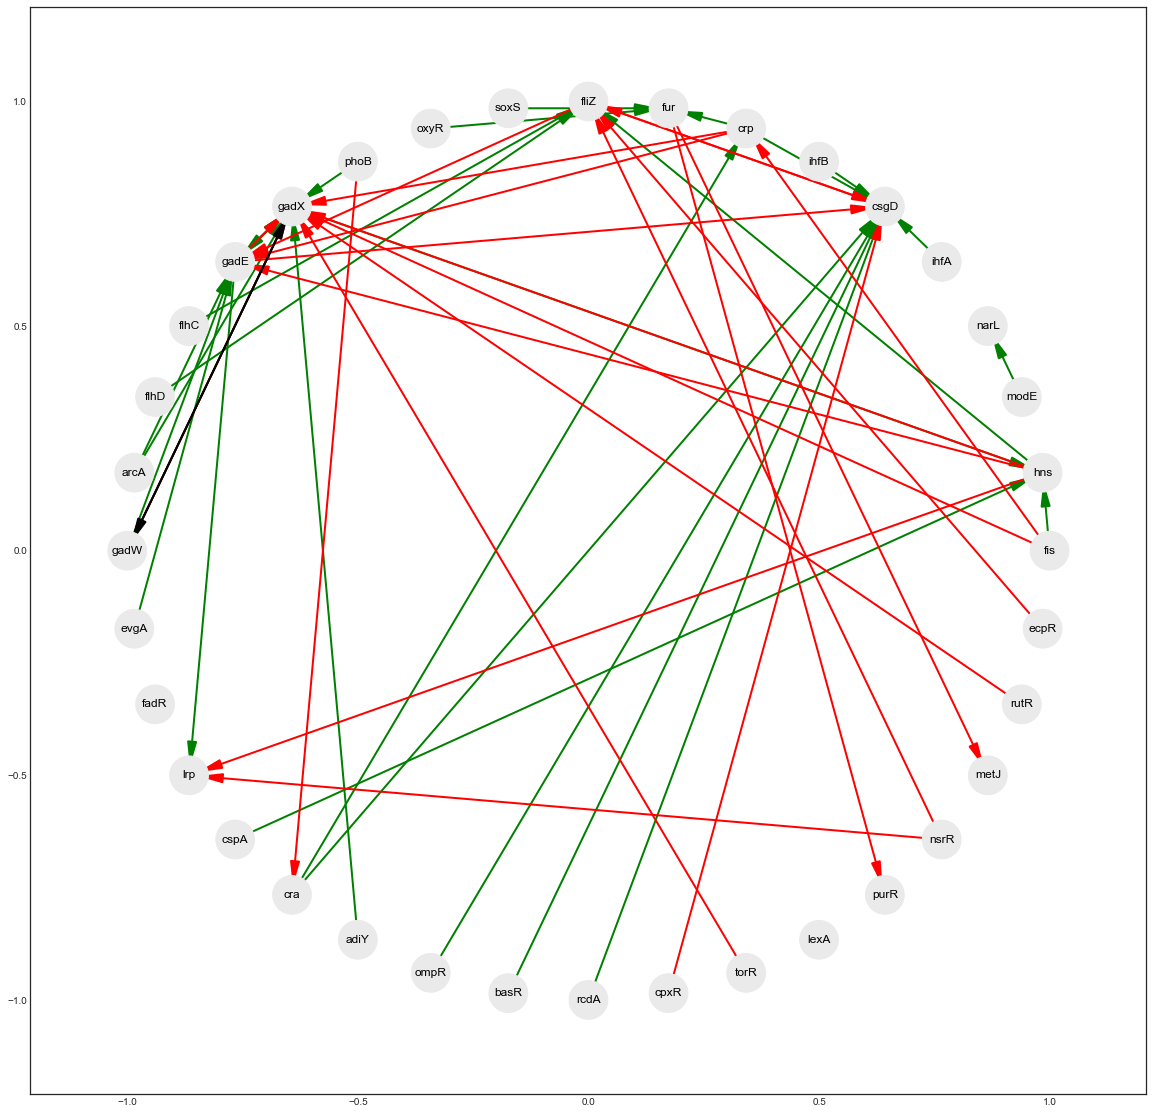

In [428]:
rreg_graph = get_graph_from_df(rreg)
found = set([g.split("_")[0] for g in ga.index])

found_graph = [g for g in rreg_graph if g[1] in found ]

fd = {}
for g in found_graph:
    if g in patient_activators:
        fd[g] = 'b'
    elif g in patient_repressors:
        fd[g] = 'skyblue'
    elif g in urine_activators:
        fd[g] = 'red'
    elif g in urine_repressors:
        fd[g] = 'orange'
    else:
        fd[g] = 'k'
        
print(fd)
draw_graph(found_graph,  val_map=fd, fs=(20,20))

17
17


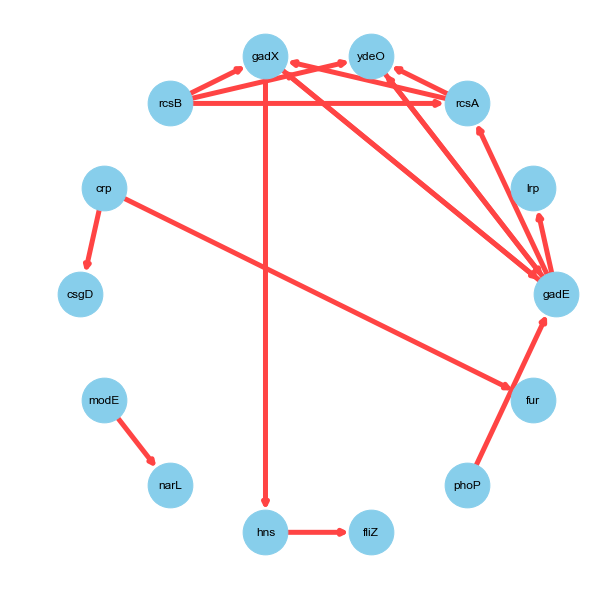

In [248]:
fig = plt.figure(figsize=(8,8))
G=nx.DiGraph()
clrs=[]
for edge in set(graph):
    if edge[2] == 'dual' or edge[2] == 'unknown' or edge[0] == edge[1]:
        continue
    elif edge[2] == 'activator':
        #continue
        clr = '#ff4444'
    else:
        continue
        clr = '#3dbe98'
    #print(len(clrs))
    old_len = len(G.edges)
    G.add_edge(edge[0], edge[1])
    new_len = len(G.edges)
    if new_len - old_len != 0:
        clrs.append(clr)
print(len(G.edges))
print(len(clrs))
nx.draw(G, with_labels=True, node_color='skyblue',node_size=2000, width=5, edge_color=clrs, pos=nx.circular_layout(G))

In [37]:
urine_gsea = ga[ga.NES > 0]
goi = set([g.split("_")[0] for g in urine_gsea.index])
goi

{'cra',
 'crp',
 'csgD',
 'fhlA',
 'fliZ',
 'fur',
 'gadE',
 'gadX',
 'hns',
 'lrp',
 'metJ',
 'modE',
 'nagC',
 'narL',
 'narP',
 'phoP',
 'rcsA',
 'rcsB',
 'ydeO'}

In [213]:
rreg.shape

(489, 4)

In [38]:
test = rreg[rreg.regulator.isin(goi)]
test2 = test[test.regulated_name.isin(goi)]
test2

,regulator,regulated_name,regulated_bnum,regulator_function
367,modE,narL,b1221,activator
1297,crp,crp,b3357,repressor
1373,crp,nagC,b0676,dual
1428,crp,csgD,b1040,activator
1441,crp,gadX,b3516,repressor
1582,crp,crp,b3357,activator
1779,crp,fur,b0683,activator
1781,crp,gadE,b3512,repressor
1841,hns,rcsB,b2217,repressor
1870,hns,rcsA,b1951,repressor


In [39]:
graph = [(frm, t, clr) for frm, t, clr in  zip(test2.regulator.values, test2.regulated_name.values, test2.regulator_function.values)]
len(set(graph))

53

In [127]:
groups = regulon.groupby(["regulator", "regulator_function"])
fis = groups.get_group(('crp', "activator"))
x = [m.split(",") for m in gsea_analysis_ds_cnts.Genes.values]
y = [m for n in x for m in n]
print(len(y))
print(len(set(y)))
683/2653


1035
683


0.25744440256313605

In [91]:
gsea_analysis_ds_cnts

,NES,FDR,Regulon Size,Matched Size,Genes
fadR_activator,-2.00179,0.0045148,12,11,"b1187,b1288,b2316,b4018,b0954,b3256,b2323,b109..."
purR_repressor,-1.75588,0.0431163,31,31,"b2551,b2904,b2905,b2903,b0033,b0032,b2553,b231..."
lexA_repressor,-1.70998,0.0418371,59,43,"b0095,b1741,b2009,b0708,b0094,b0958,b1860,b008..."
cra_repressor,-1.66859,0.0444708,59,50,"b3956,b2097,b0118,b3919,b1818,b2712,b2388,b181..."
mlrA_activator,-1.6215,0.0519202,10,10,"b1040,b1038,b1039,b1037,b4133,b3185,b3183,b319..."
fis_activator,-1.57226,0.0644111,151,57,"b2579,b4382,b3845,b2239,b1237,b4032,b2241,b384..."
soxS_activator,-1.56929,0.0563705,38,26,"b0871,b3924,b0762,b1611,b2159,b2237,b3037,b303..."
rcsA_activator,1.51163,0.0961402,42,24,"b1482,b0095,b3510,b3509,b1492,b3506,b3507,b351..."
fliZ_repressor,1.56802,0.0702634,20,15,"b1040,b3510,b1038,b1042,b1041,b3509,b1492,b103..."
gadE_activator,1.56842,0.073909,70,38,"b0889,b3212,b1482,b0095,b3510,b3509,b1492,b017..."


In [85]:
gsea_analysis_ds_cnts = run_gsea(ds_cnts, gene_set, cls, results_dir, 'gsea_with_deseq2')

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [44]:
tgsea = set(gsea_analysis_tpm.index)
dgsea = set(gsea_analysis_ds_cnts.index)
tgsea

{'crp_activator',
 'csgD_activator',
 'fadR_activator',
 'fis_activator',
 'lrp_activator',
 'lrp_repressor',
 'metJ_repressor',
 'mlrA_activator',
 'narL_repressor',
 'purR_repressor'}

In [37]:
len(tgsea.intersection(dgsea))
len(dgsea)

28

In [41]:
ds_cnts.loc['b4070']

HM01_UR     614.064154
HM01_UTI     27.155104
HM03_UR     147.915326
HM03_UTI     37.162002
HM06_UR     220.426333
HM06_UTI     60.860170
HM07_UR      70.103902
HM07_UTI     69.611974
HM14_UR      72.701351
HM14_UTI     54.213035
HM17_UR     159.273197
HM17_UTI     15.449096
HM43_UR     382.428791
HM43_UTI     51.014075
HM54_UR     136.632697
HM54_UTI     59.958402
HM56_UR     156.292008
HM56_UTI     24.717477
HM57_UR     192.908891
HM57_UTI    222.640766
HM60_UR      77.199694
HM60_UTI    223.267015
HM66_UR     221.299602
HM66_UTI    681.893777
HM68_UR     179.324727
HM68_UTI     53.760470
HM86_UR     186.037898
HM86_UTI     44.681872
Name: b4070, dtype: float64

In [43]:
ds_cnts.loc['b1222']

HM01_UR      913.503174
HM01_UTI     482.003089
HM03_UR     1076.077521
HM03_UTI     935.608044
HM06_UR     1033.196317
HM06_UTI     717.837901
HM07_UR     1056.661874
HM07_UTI    1400.429118
HM14_UR     1021.857877
HM14_UTI     638.587309
HM17_UR      524.471696
HM17_UTI     247.185534
HM43_UR     1313.401814
HM43_UTI     569.003141
HM54_UR      488.960831
HM54_UTI     420.884470
HM56_UR      762.604434
HM56_UTI     726.452674
HM57_UR     1295.912147
HM57_UTI     564.553371
HM60_UR      815.205725
HM60_UTI     457.165792
HM66_UR      875.393996
HM66_UTI     426.183611
HM68_UR     1037.497331
HM68_UTI     416.643644
HM86_UR      950.193566
HM86_UTI     685.547576
Name: b1222, dtype: float64

In [26]:
gsea_analysis_ds_cnts

,NES,FDR,Regulon Size,Matched Size,Genes
fadR_activator,-1.9948,0.00383229,12,11,"b1187,b1288,b2316,b4018,b0954,b3256,b2323,b109..."
purR_repressor,-1.76433,0.0347035,31,31,"b2551,b2904,b2905,b2903,b0033,b0032,b2553,b231..."
lexA_repressor,-1.73869,0.0288131,59,43,"b0095,b1741,b2009,b0708,b0094,b0958,b1860,b008..."
cra_repressor,-1.70872,0.0284228,59,50,"b2097,b3956,b0118,b3919,b2712,b1818,b2388,b181..."
mlrA_activator,-1.60738,0.0529707,10,10,"b1040,b1038,b1039,b1037,b4133,b3185,b3190,b318..."
soxS_activator,-1.59232,0.0502456,38,26,"b0871,b1611,b3924,b0762,b2159,b2237,b3037,b303..."
fis_activator,-1.48303,0.0923399,151,57,"b2579,b4382,b3845,b2239,b4032,b2241,b1237,b148..."
nac_activator,1.49803,0.0960442,12,10,"b2662,b1441,b1440,b1444,b1442,b1443,b2393,b266..."
cra_activator,1.51967,0.0875794,23,18,"b3357,b1040,b4014,b1136,b1038,b0871,b3403,b103..."
narP_repressor,1.60738,0.0488786,33,26,"b1671,b1669,b0975,b0976,b2202,b2204,b2199,b220..."


In [73]:
[regulon[regulon['regulated_bnum'] == x].regulated_name for x in lr]

[1993    lrp
 2794    lrp
 2795    lrp
 3520    lrp
 4367    lrp
 Name: regulated_name, dtype: object, 1494    serA
 1823    serA
 2748    serA
 2752    serA
 Name: regulated_name, dtype: object, 1853    ilvI
 2796    ilvI
 2808    ilvI
 Name: regulated_name, dtype: object, 1941    osmC
 2182    osmC
 2280    osmC
 2316    osmC
 2689    osmC
 2740    osmC
 2789    osmC
 Name: regulated_name, dtype: object, 2716    livF
 Name: regulated_name, dtype: object, 2699    livM
 Name: regulated_name, dtype: object, 403     oppA
 2605    oppA
 2718    oppA
 4548    oppA
 Name: regulated_name, dtype: object, 1898    hdeA
 2200    hdeA
 2276    hdeA
 2318    hdeA
 2749    hdeA
 2892    hdeA
 2949    hdeA
 2973    hdeA
 3024    hdeA
 3524    hdeA
 3738    hdeA
 4842    hdeA
 Name: regulated_name, dtype: object, 531     ilvM
 559     ilvM
 737     ilvM
 820     ilvM
 2706    ilvM
 2707    ilvM
 Name: regulated_name, dtype: object, 2751    alaA
 Name: regulated_name, dtype: object, 2700    aidB
 3776

In [71]:
la = gsea_analysis_ds_cnts.loc['lrp_activator'].Genes.split(',')
lr = gsea_analysis_ds_cnts.loc['lrp_repressor'].Genes.split(',')
print([a for a in la if a in lr])
la

['b2913', 'b0077', 'b1482', 'b0078']


['b2913',
 'b2923',
 'b3212',
 'b2904',
 'b0907',
 'b2905',
 'b0077',
 'b1482',
 'b2903',
 'b2662',
 'b0078',
 'b3418',
 'b2163',
 'b4132',
 'b2663',
 'b3617',
 'b2211',
 'b2669',
 'b2156']

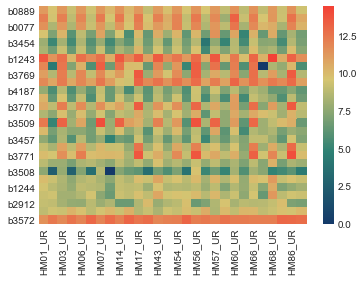

In [65]:
sns.heatmap(np.log2(ds_cnts.loc[lr]+1), cmap=my_cmap)

In [35]:
matched_genes = gsea_analysis.sum().Genes.split(",")
matched_genes_o = [c for c in matched_genes if len(c)>6]
matched_genes = [c for c in matched_genes if len(c)<6]
ot = []
for g in matched_genes_o:
    f = g[:5]
    s = g[5:]
    ot.append(f)
    ot.append(s)
matched_genes+=ot
len(set(matched_genes))

464

In [126]:
gene_set = repressor_gmt
repressed = run_gsea(tpm, gene_set, cls, results_dir)
repressed

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


,NES,FDR,Regulon Size,Matched Size,Genes
purR,-1.79497,0.0245499,31,31,"b2903,b2905,b2551,b2904,b0033,b0032,b2553,b417..."
hns,1.50994,0.0862242,144,62,"b0889,b0757,b0077,b0758,b0759,b0756,b1482,b123..."
nagC,1.53374,0.0821418,33,27,"b1736,b1735,b1733,b0679,b1734,b1738,b0676,b431..."
fur,1.5624,0.0752262,110,66,"b3212,b3070,b4019,b2741,b0167,b0928,b3409,b257..."
narL,1.76818,0.0126697,87,65,"b4139,b1671,b4138,b1669,b2993,b4040,b4153,b062..."
metJ,1.89945,0.00158371,15,14,"b2153,b0197,b0199,b3828,b3829,b3008,b2152,b019..."
lrp,1.91921,0.00316742,85,27,"b0889,b2913,b0077,b3454,b1482,b3456,b0078,b229..."


In [167]:
def vis_regulon(regulator, regulon_anlaysis_table, counts, figsize=(12,6)):
    regulon = regulon_anlaysis_table.loc[regulator].Genes.split(",")
    print(len(regulon))
    regulon_expr = counts.loc[regulon]
    
    sns.clustermap(np.log2(regulon_expr+1), cmap=my_cmap, linewidths=0.5, linecolor='black', figsize=figsize)
    return f

27


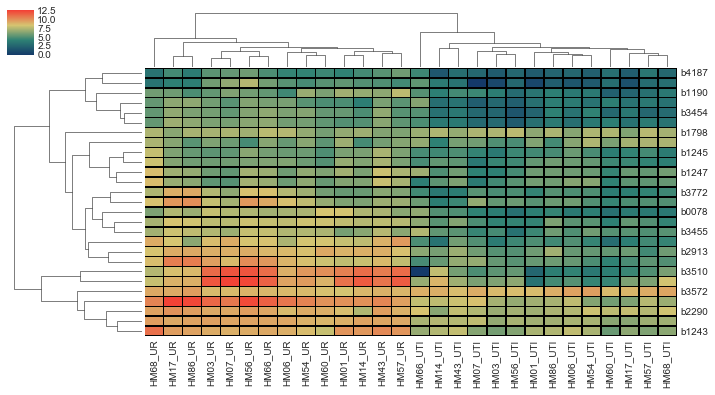

In [168]:
f = vis_regulon('lrp', repressed, tpm)

19


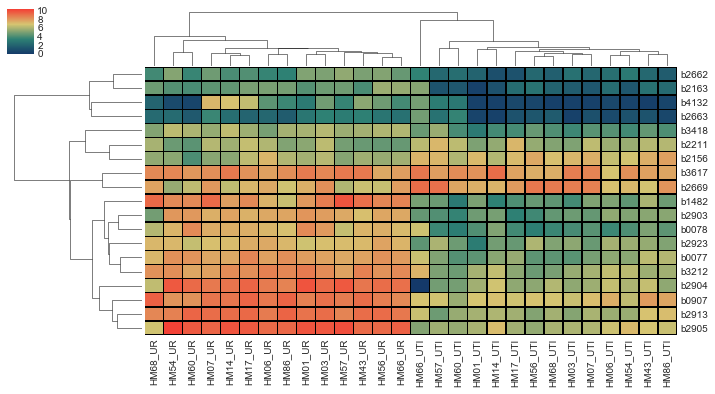

In [169]:
f = vis_regulon('lrp', activated, tpm)

31


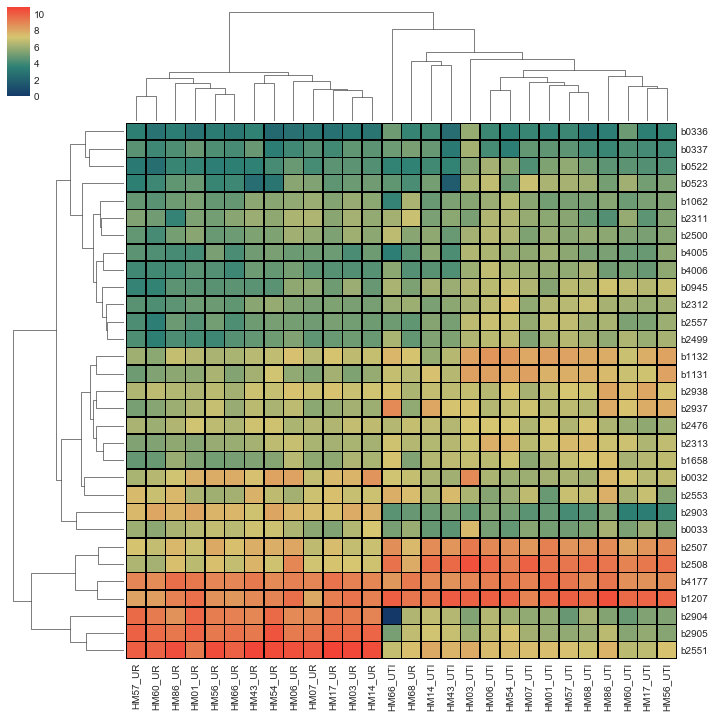

In [177]:
f = vis_regulon('purR', repressed, tpm, (12, 12))

11


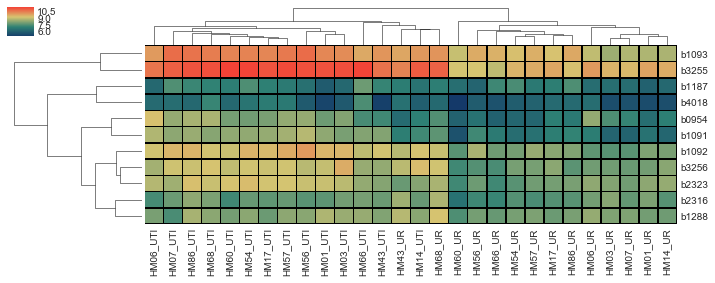

In [175]:
f = vis_regulon('fadR', activated, tpm, (12, 4))

66


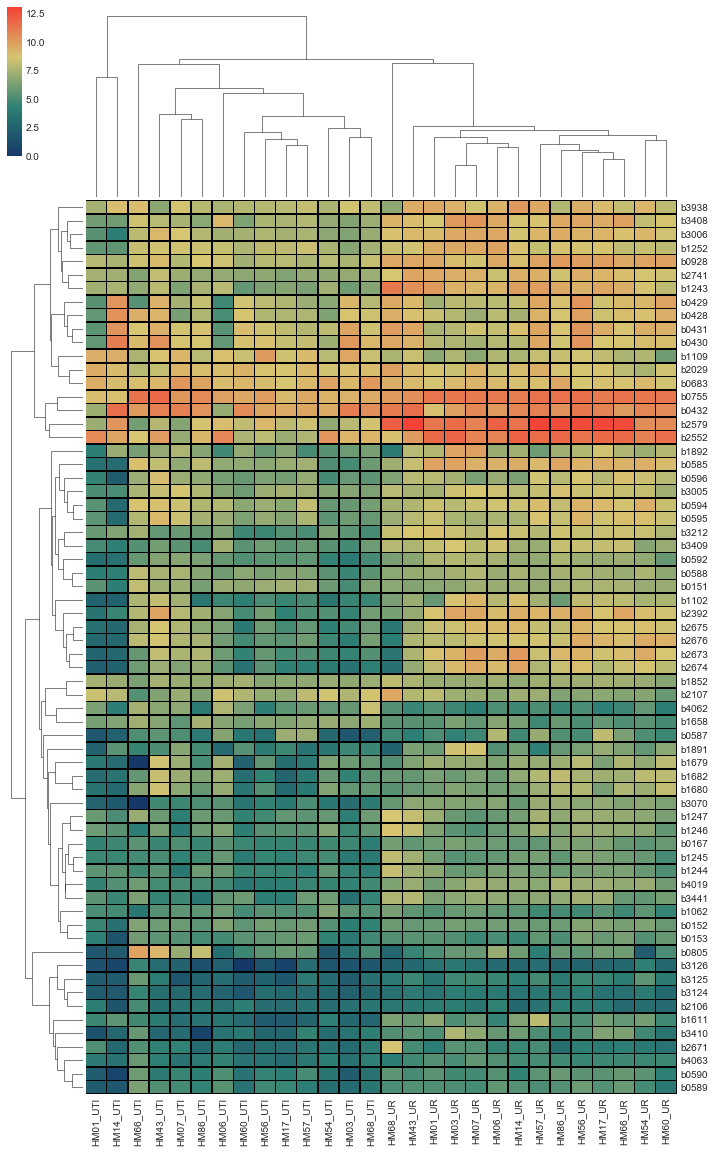

In [179]:
f = vis_regulon('fur', repressed, tpm, (12, 20))

65


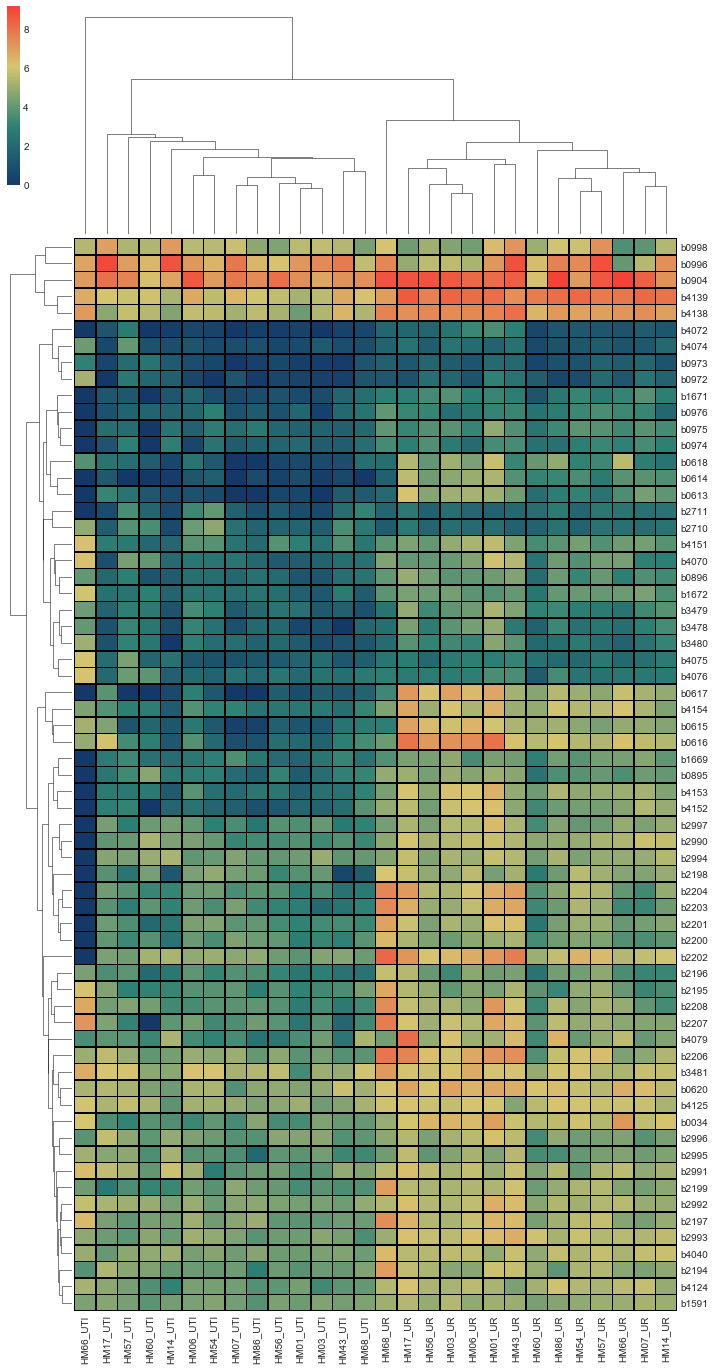

In [182]:
f = vis_regulon('narL', repressed, tpm, (12, 24))

In [87]:
gene_set = repressor_gmt
repressors_t_test = gseapy.gsea(data=tpm, gene_sets=gene_set, cls=cls, outdir=results_dir,
                                min_size=5, method="t_test")

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [90]:
res = pd.DataFrame(repressors_t_test.results).T
res = res[["es", "nes", "pval", "fdr", "geneset_size", "matched_size", "genes"]]
res_uti = res[(res.nes>0) & (res.pval < 0.05)].sort_values(by=["pval", "fdr"])
print(res)

              es       nes        pval        fdr geneset_size matched_size  \
acrR   -0.344671 -0.855819    0.629333          1           11            7   
agaR    0.708129   1.63309   0.0153846  0.0657905           11            8   
allR    0.379716  0.821244    0.723437   0.778952            9            7   
arcA   -0.253852  -1.17796    0.124378   0.847155          126           88   
argR    0.332138   1.03074    0.436893   0.568429           33           26   
cecR    0.647608    1.2704    0.125203   0.333809            5            5   
cpxR    0.355691   1.04798    0.411932   0.552074           24           19   
cra    -0.341586   -1.4679   0.0207469   0.326501           59           50   
crp      0.29775   1.15828    0.228869   0.443038          113           77   
csgD    0.817439   1.80187           0  0.0268839           15            7   
cueR    0.681308   1.34866    0.100977   0.266625            5            5   
cytR    0.489978   1.28511    0.166419   0.335996   

In [50]:
# df = pd.read_csv(data_set, index_col = 0)
# cls = [0]*14 + [1]*14 # list describing which condition each sample belongs to
# print(df.shape)
# print(df.head())


(2690, 28)
           HM01_UR      HM03_UR      HM06_UR      HM07_UR      HM14_UR  \
b0002  1809.173226  1485.090948  1034.399500  1882.376734  1672.556833   
b0003   638.119239   386.325207   543.177820   410.247872   556.587158   
b0004   481.900793   471.342594   385.642360   372.514702   471.173392   
b0006   744.472445   856.634156  1241.946217   967.414258   931.475941   
b0007   174.528339   191.999752   162.536585   177.158572   157.471925   

           HM17_UR      HM43_UR      HM54_UR      HM56_UR      HM57_UR  \
b0002  1734.666078  1299.616272  1543.683343  1807.172459   952.242212   
b0003   557.246473   528.651856   793.521540  1544.577527   432.660989   
b0004   551.062929   652.456361   722.918076   892.906532   471.076628   
b0006  1170.872322  1213.217941  1031.040801   978.762929  1190.496784   
b0007   243.704398   233.374802   250.949268   252.962263   363.202409   

          ...          HM14_UTI     HM17_UTI     HM43_UTI     HM54_UTI  \
b0002     ...       1777.

In [37]:
activators_t_test = gseapy.gsea(data=df, gene_sets=gene_set, cls=cls, outdir=outdir,
                        min_size=5, method="t_test")

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [49]:
res = pd.DataFrame(activators_t_test.results).T
res = res[["es", "nes", "pval", "fdr", "geneset_size", "matched_size", "genes"]]
print(res.shape[0])
res_uti = res[(res.nes<0) & (res.pval < 0.05)].sort_values(by=["pval", "fdr"])
print(res_uti)
res_uti.to_csv(os.path.join(outdir, "2018-07-17-t-test-a-uti.csv"))


56
                    es      nes       pval        fdr geneset_size  \
ECK120000275 -0.761567 -2.00866          0  0.0034911           12   
ECK120000311  -0.39372 -1.59107  0.0126126   0.103424          151   
ECK120001927 -0.643648 -1.68168  0.0196078  0.0709131           10   
ECK120000947 -0.464624 -1.55892  0.0307971   0.101351           38   

             matched_size                                              genes  
ECK120000275           10  b1187,b1288,b2316,b4018,b0954,b3256,b2323,b109...  
ECK120000311           57  b2579,b4382,b3845,b2239,b1237,b4032,b2241,b384...  
ECK120001927           10  b1040,b1038,b1039,b1037,b4133,b3185,b3190,b318...  
ECK120000947           26  b0871,b3924,b0762,b1611,b2159,b2237,b3037,b303...  


In [50]:
res_ur = res[(res.nes>0) & (res.pval < 0.05)].sort_values(by=["pval", "fdr"])
res_ur.to_csv(os.path.join(outdir, "2018-07-17-t-test-a-ur.csv"))
res_ur


,es,nes,pval,fdr,geneset_size,matched_size,genes
ECK120000160,0.376158,2.05733,0,0.00273433,421,272,"b3429,b3430,b1622,b3357,b0757,b4138,b2804,b284..."
ECK120000540,0.68502,2.19788,0,0.00328119,38,20,"b2923,b2913,b0907,b3212,b0077,b2904,b2905,b290..."
ECK120003142,0.724414,2.0616,0,0.00410149,13,13,"b3661,b1003,b0382,b1004,b1040,b0964,b1038,b104..."
ECK120002995,0.550048,1.93503,0,0.00861312,31,28,"b0782,b0784,b0783,b1221,b2202,b0785,b2199,b220..."
ECK120002953,0.754196,1.91206,0.00222717,0.00820298,10,9,"b3236,b0617,b0620,b3093,b0614,b0615,b0616,b061..."
ECK120000811,0.564702,1.86665,0.00430108,0.0131248,38,20,"b1482,b0095,b3510,b3509,b1492,b3506,b3507,b351..."
ECK120000812,0.564702,1.85155,0.00631579,0.0133591,38,20,"b1482,b0095,b3510,b3509,b1492,b3506,b3507,b351..."
ECK120002126,0.564175,1.71216,0.00838574,0.0419992,23,16,"b2741,b1492,b3506,b1237,b3507,b3516,b3511,b045..."
ECK120001498,0.465001,1.71838,0.00854701,0.0448429,66,34,"b0889,b3212,b1482,b0095,b3510,b3509,b1492,b017..."
ECK120001481,0.469021,1.70402,0.00873362,0.0413132,32,29,"b2202,b1796,b0872,b2199,b2204,b1797,b2206,b219..."


In [40]:
activators_log2 = gseapy.gsea(data=df, gene_sets=gene_set, cls=cls, outdir=outdir, min_size=5)

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [41]:
res2 = pd.DataFrame(activators_log2.results).T
res2 = res2[["es", "nes", "pval", "fdr", "geneset_size", "matched_size", "genes"]]
print(res2.shape[0])
res2_uti = res2[(res2.nes<0) & (res2.pval < 0.05)].sort_values(by=["pval", "fdr"])
res2_uti


56


,es,nes,pval,fdr,geneset_size,matched_size,genes
ECK120000275,-0.682966,-1.81589,0.0112676,0.0671615,12,10,"b2316,b1288,b1187,b4018,b2323,b3256,b1092,b095..."
ECK120000313,-0.336339,-1.40873,0.0273224,0.459821,78,54,"b2243,b2242,b2241,b2204,b0655,b2203,b4072,b192..."
ECK120000947,-0.426292,-1.48488,0.048583,0.459084,38,26,"b0871,b1611,b0762,b3924,b2237,b2159,b3037,b303..."


In [31]:
active_results_uti_merge = pd.merge(res_uti, res2_uti, how="outer", left_index=True, right_index=True)
active_results_uti_merge
active_results_uti_merge.to_csv(os.path.join(outdir, "2018-07-17-active-uti.csv"))

In [33]:
res2_ur = res2[(res2.nes>0) & (res2.pval < 0.05)].sort_values(by=["pval", "fdr"])
res2_ur
active_results_ur_merge = pd.merge(res_ur, res2_ur, how="outer", left_index=True, right_index=True)
active_results_ur_merge
#active_results_ur_merge.to_csv(os.path.join(outdir, "2018-07-17-active-ur.csv"))

In [42]:
res2_ur

,es,nes,pval,fdr,geneset_size,matched_size,genes
ECK120000160,0.602941,2.40559,0,0,421,272,"b3708,b4311,b0344,b4310,b3132,b3222,b3223,b356..."
ECK120000811,0.807535,2.19892,0,0,38,20,"b1480,b3510,b1492,b3509,b1482,b3506,b3516,b413..."
ECK120000812,0.807535,2.2831,0,0,38,20,"b1480,b3510,b1492,b3509,b1482,b3506,b3516,b413..."
ECK120001498,0.718606,2.217,0,0,66,34,"b1480,b3510,b1492,b3509,b1482,b3506,b3516,b351..."
ECK120002953,0.890867,2.01682,0,0.000210943,10,9,"b3093,b0614,b0617,b0613,b0618,b3236,b0616,b061..."
ECK120003142,0.775082,1.9686,0,0.000351572,13,13,"b1004,b1040,b1003,b0382,b1039,b1038,b1042,b366..."
ECK120004419,0.874483,1.81421,0,0.0028628,8,7,"b3939,b3940,b0199,b0197,b0198,b2762,b0734"
ECK120002334,0.863628,1.81802,0,0.00292075,9,7,"b3708,b3510,b3709,b3509,b3508,b0998,b0996"
ECK120000961,0.863193,1.80763,0,0.00295321,7,7,"b2703,b2702,b2705,b2704,b2706,b2708,b2707"
ECK120002449,0.945996,1.79776,0,0.00316415,6,5,"b3566,b3565,b3567,b3568,b3569"


In [43]:
df = pd.read_csv(data_set, index_col = 0)
gene_set = "/Users/annasintsova/git_repos/HUTI-RNAseq/results/regulon_analysis/repressor.gmt"
repressors_t_test = gseapy.gsea(data=df, gene_sets=gene_set, cls=cls, outdir=outdir, min_size=5, method="t_test")

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [51]:
rres = pd.DataFrame(repressors_t_test.results).T
rres = rres[["es", "nes", "pval", "fdr", "geneset_size", "matched_size", "genes"]]
print(rres.shape[0])
rres_uti = rres[(rres.nes>0) & (rres.pval < 0.05)].sort_values(by=["pval", "fdr"])
rres_uti.to_csv(os.path.join(outdir, "2018-07-17-t-test-r-uti.csv"))
rres_uti

64


,es,nes,pval,fdr,geneset_size,matched_size,genes
ECK120000540,0.626422,2.19725,0,0,85,28,"b0889,b2913,b0077,b3454,b3456,b1482,b1243,b229..."
ECK120000636,0.527333,2.28622,0,0,87,67,"b4138,b4139,b1671,b1669,b4153,b4040,b4152,b415..."
ECK120000581,0.708943,2.05169,0,0.000525849,15,14,"b2153,b0197,b0199,b3828,b3008,b0198,b3829,b394..."
ECK120004180,0.799031,1.94307,0,0.00670457,11,8,"b3137,b3136,b3139,b3138,b3140,b3141,b3132,b3133"
ECK120000352,0.429483,1.86396,0,0.0157755,110,67,"b4019,b3212,b3070,b2741,b3409,b1243,b0585,b016..."
ECK120002377,0.767425,1.80948,0,0.0195221,9,7,"b3094,b3092,b1521,b4322,b3093,b3091,b4324"
ECK120000357,0.752796,1.84319,0.002079,0.0155125,11,8,"b0757,b0756,b0758,b0759,b2149,b2837,b2150,b2151"
ECK120000450,0.376932,1.58732,0.00222222,0.0916104,144,62,"b0889,b0757,b0077,b0756,b0758,b1482,b4238,b196..."
ECK120004225,0.762579,1.72918,0.00395257,0.0436454,10,7,"b3222,b3223,b3225,b3221,b4310,b4309,b4311"
ECK120000358,0.752796,1.82222,0.00408998,0.0187052,11,8,"b0757,b0756,b0758,b0759,b2149,b2837,b2150,b2151"


In [45]:
repressors_log2 = gseapy.gsea(data=df, gene_sets=gene_set, cls=cls, outdir=outdir, min_size=5)

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [46]:
rres2 = pd.DataFrame(repressors_log2.results).T
rres2 = rres2[["es", "nes", "pval", "fdr", "geneset_size", "matched_size", "genes"]]
print(rres2.shape[0])
rres2_uti = rres2[(rres2.nes>0) & (rres2.pval < 0.05)].sort_values(by=["pval", "fdr"])
rres2_uti

64


,es,nes,pval,fdr,geneset_size,matched_size,genes
ECK120000540,0.711041,2.09934,0,0,85,28,"b3510,b3509,b1482,b3769,b3770,b3771,b3772,b007..."
ECK120000581,0.808216,2.07033,0,0,15,14,"b3829,b3941,b4013,b3828,b3939,b3940,b3008,b019..."
ECK120004180,0.960104,2.13503,0,0,11,8,"b3137,b3132,b3139,b3136,b3138,b3133,b3140,b3141"
ECK120004225,0.9918,2.0713,0,0,10,7,"b4311,b4310,b3222,b3223,b3225,b4309,b3221"
ECK120000357,0.90747,1.96954,0,0.000381888,11,8,"b2150,b2149,b0757,b0758,b0756,b2151,b0759,b2837"
ECK120000358,0.90747,1.98794,0,0.000458265,11,8,"b2150,b2149,b0757,b0758,b0756,b2151,b0759,b2837"
ECK120001325,0.740878,1.9276,0,0.00130933,20,15,"b3510,b1492,b1040,b3509,b1039,b1038,b3512,b104..."
ECK120000636,0.542494,1.88786,0,0.00200491,87,67,"b0614,b0617,b0613,b0618,b4152,b0616,b4153,b061..."
ECK120002159,0.846867,1.84559,0,0.00330969,10,8,"b3575,b3581,b3582,b3576,b3579,b3583,b3574,b3580"
ECK120000963,0.863193,1.79123,0,0.00583247,7,7,"b2703,b2702,b2705,b2704,b2706,b2708,b2707"


In [52]:
rres_ur = rres[(rres.nes<0) & (rres.pval < 0.05)].sort_values(by=["pval", "fdr"])
rres_ur.to_csv(os.path.join(outdir, "2018-07-17-t-test-r-ur.csv"))
rres_ur

,es,nes,pval,fdr,geneset_size,matched_size,genes
ECK120000526,-0.455729,-1.74815,0.003663,0.111518,59,44,"b0095,b1741,b2009,b0708,b0094,b0958,b1860,b008..."
ECK120000791,-0.499278,-1.73921,0.0069808,0.061478,31,31,"b2551,b2904,b2905,b2903,b0033,b0032,b2553,b231..."
ECK120000332,-0.433024,-1.69591,0.00746269,0.0465851,59,50,"b3956,b2097,b0118,b3919,b1818,b2712,b2388,b181..."
ECK120000229,-0.675802,-1.71888,0.0289256,0.0509934,11,9,"b3461,b1415,b2234,b2235,b3701,b3702,b2507,b250..."


In [48]:
rres2_ur = rres2[(rres2.nes<0) & (rres2.pval < 0.05)].sort_values(by=["pval", "fdr"])
rres2_ur

,es,nes,pval,fdr,geneset_size,matched_size,genes
ECK120000791,-0.514371,-1.87335,0,0.0194301,31,31,"b2904,b2905,b2903,b2551,b0033,b0032,b2553,b231..."
ECK120000332,-0.453828,-1.91228,0,0.0254357,59,50,"b2097,b0118,b2712,b3956,b1818,b3366,b1817,b391..."
ECK120000526,-0.379294,-1.52495,0.0241546,0.204016,59,44,"b0708,b2009,b1741,b0095,b0958,b0094,b1860,b008..."
ECK120002020,-0.699436,-1.51412,0.040201,0.175789,9,6,"b4063,b0464,b0463,b1531,b1532,b4062"


In [34]:
r_results_uti_merge = pd.merge(rres_uti, rres2_uti, how="outer", left_index=True, right_index=True)
r_results_uti_merge.to_csv(os.path.join(outdir, "2018-07-17-rep-uti.csv"))
r_results_ur_merge = pd.merge(rres_ur, rres2_ur, how="outer", left_index=True, right_index=True)
r_results_ur_merge.to_csv(os.path.join(outdir, "2018-07-17-rep-ur.csv"))

In [11]:
ranked_list_file = "/Users/annasintsova/git_repos/HUTI-RNAseq/results/differential_expression_analysis/best_strains_DEseq.csv"

In [12]:
ranked_list = pd.read_csv(ranked_list_file, index_col=0)
ranked_list.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
b4311,5891.031100,-7.249431,0.742999,-9.756991,1.720000e-22,6.470000e-21
b3708,12449.334130,-7.060795,0.900563,-7.840423,NaN,NaN
b0344,8140.244287,-6.848421,0.648985,-10.552509,4.950000e-26,2.960000e-24
b3136,2957.506332,-6.799896,0.537702,-12.646220,1.170000e-36,2.210000e-34
b3137,1551.851262,-6.652559,0.650377,-10.228776,1.470000e-24,7.460000e-23


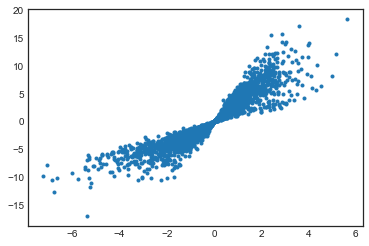

In [8]:
plt.plot(ranked_list.log2FoldChange, ranked_list.stat, '.')

In [22]:
r1 = ranked_list[["log2FoldChange"]]
r1.shape

(2690, 1)

In [47]:
de = set(r1[(r1.log2FoldChange > 1) | (r1.log2FoldChange < -1)].index)

In [15]:
?gseapy.prerank

In [14]:
pr = gseapy.prerank(r1, regulon_gmt, outdir=results_dir, min_size=10, no_plot=True)

In [15]:
d = pd.DataFrame(pr.results).T
results_short = (d[["nes", "fdr",  "geneset_size", "matched_size", "genes"]][d.fdr < 0.1]
                     .sort_values(["nes", "fdr"]))

In [16]:
results_short

,nes,fdr,geneset_size,matched_size,genes
crp_activator,-2.51178,0,425,276,"b1101,b2508,b3260,b3261,b2927,b4203,b0820,b420..."
narL_repressor,-2.46759,0,87,67,"b2710,b2711,b0996,b0998,b2996,b2995,b3481,b299..."
lrp_repressor,-2.41164,0,85,28,"b1798,b3572,b2912,b2215,b1244,b1246,b2290,b124..."
modE_activator,-2.13609,0.00144418,31,28,"b0781,b2200,b2195,b2198,b1222,b2194,b2197,b078..."
metJ_repressor,-2.04755,0.00385114,15,14,"b0606,b2152,b2942,b0197,b0198,b2153,b0199,b401..."
lrp_activator,-2.04586,0.00320929,38,20,"b2156,b2669,b2211,b3617,b0908,b0907,b2663,b321..."
csgD_activator,-2.0447,0.00275082,13,13,"b1043,b1037,b0385,b1041,b0964,b1039,b1038,b104..."
rcsB_activator,-2.0224,0.00312906,58,28,"b2570,b2571,b4115,b0891,b2573,b3800,b4027,b318..."
crp_unknown,-2.00051,0.00385114,12,10,"b4239,b1611,b4240,b3579,b3580,b3576,b3583,b358..."
hns_repressor,-1.9625,0.00462137,144,62,"b3556,b3265,b2669,b3367,b2678,b2679,b3365,b366..."


In [33]:
pr = gseapy.prerank(r1, repressor_gmt, outdir=results_dir, min_size=10, no_plot=True)

In [34]:
d = pd.DataFrame(pr.results).T
results_short_b = (d[["nes", "fdr",  "geneset_size", "matched_size", "genes"]][d.fdr < 0.1]
                     .sort_values(["nes", "fdr"]))

In [39]:
results_short

,nes,fdr,geneset_size,matched_size,genes
narL,-2.44894,0,87,67,"b2710,b2711,b0996,b0998,b2996,b2995,b3481,b299..."
lrp,-2.44516,0,85,28,"b1798,b3572,b2912,b2215,b1244,b1246,b2290,b124..."
metJ,-2.10116,0.000673401,15,14,"b0606,b2152,b2942,b0197,b0198,b2153,b0199,b401..."
hns,-1.90648,0.00555556,144,62,"b3556,b3265,b2669,b3367,b2678,b2679,b3365,b366..."
fliZ,-1.78864,0.0133333,20,15,"b1043,b1037,b1892,b3512,b1891,b3513,b1041,b350..."
narP,-1.69431,0.0232323,33,27,"b2710,b1475,b1476,b2711,b0974,b2200,b0972,b219..."
crp,-1.48594,0.0989899,113,79,"b3170,b3169,b3231,b3165,b2416,b3168,b2415,b316..."
pdhR,1.40518,0.0882434,36,29,"b0093,b0081,b0092,b0091,b1109,b0090,b0089,b011..."
purR,1.48008,0.0659084,31,31,"b2508,b0945,b2507,b1207,b1658,b2499,b2937,b255..."
lexA,1.6039,0.0307924,59,44,"b3065,b0685,b3066,b3067,b0093,b0092,b1728,b184..."


In [43]:
len(de.intersection(set(matched_genes)))

289

In [48]:
len(de.intersection(set(matched_genes)))/len(de)

0.2306464485235435